## Problem Statement
Support Vector Machine
1. Given a dataset which contains a excerpts of text written by some author and the corresponding author tag, implement an SVM classier to predict the author tag of the test text excerpts.
2. For the feature extraction of the text segments, either use Vectorizers provided in sklearn or use pre-trained word embedding models. ( Code snippet for usage of word embedding models is given here).
3. Visualize the feature vectors and see if you could nd some pattern.
4. Tweak dierent parameters of the Linear SVM and report the results.
5. Experiment dierent kernels for classication and report the results.
6. Report accuracy score, F1-score, Confusion matrix and any other metrics you feel useful.
7. (Bonus-20 points) You may do some pre-processing on textual data to improve your classier. Explain why score has improved if it did.
8. Link to the dataset has been provided in the common link.
9. You can use inbuilt functions for SVM.
10. The code le must be a python(.py) le. You are expected to dene a class for each question which is compatible with the test.py le provided here. Make sure your code can be run by "python test.py". Double check this.

## Introduction
SVM classifier (SVC) from sklearn has been used for this implementation. 

We use TFID vectorizer to convert text into a sparse matrix that can be used in the classifier. We use standard SVM classifier (SVC) in sklearn for the actual classification. We try out 4 different algorithms for kernel: 
1. Linear
2. Polynomial (degree 3)
3. rbf
4. sigmoid


In [1]:
import numpy as np
import time
from sklearn import svm
import pickle
import sklearn.metrics as metrics
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import q5


### Check out basic fit and predict of linear model using training data and exposed APIs (train and predict)
We run the algorithm on the provided data. We then use the same data as test data to get the prediction. The accuracy score is more than 92% which shows that algorithm runs well.  

In [2]:
ac = q5.AuthorClassifier()
time1 = time.time()
ac.train("./Datasets/Question-5/train.csv")
time2 = time.time()
predicted_labels = ac.predict("./Datasets/Question-5/train.csv", labels = True)
time3 = time.time()


In [6]:
print("Predicted: ", predicted_labels.shape, "Actual: ", ac.vlabels.shape)

f1_score = metrics.f1_score(ac.vlabels, predicted_labels, average = 'macro')
conf_matrix = metrics.confusion_matrix(ac.vlabels, predicted_labels)

print("Kernel: Linear, ", " Fit Time: ", time2 - time1, " Predict Time: ", time3 - time2)
print("Accuracy Score: ", ac.vscore, "F1 Score: ", f1_score)
print("\nConfusion Matrix: ")
print(conf_matrix)


Predicted:  (15663,) Actual:  (15663,)
Kernel: Linear,   Fit Time:  31.70426034927368  Predict Time:  31.34123134613037
Accuracy Score:  0.9253655110770606 F1 Score:  0.9254637213044435

Confusion Matrix: 
[[5960  158  198]
 [ 284 4132   93]
 [ 327  109 4402]]


## Visualize the data to see patterns
We draw PCA for better visualization, given that data is a sparse matrix. 

In [13]:
# Visualize the data
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

tX1 = ac.tX.todense()
pca = PCA(n_components=2).fit(tX1)
data2D = pca.transform(tX1)
pcadf = pd.DataFrame(data = data2D, columns = ['PCA1', 'PCA2'])
finaldf = pd.concat([pcadf, ac.tlabels], axis = 1)



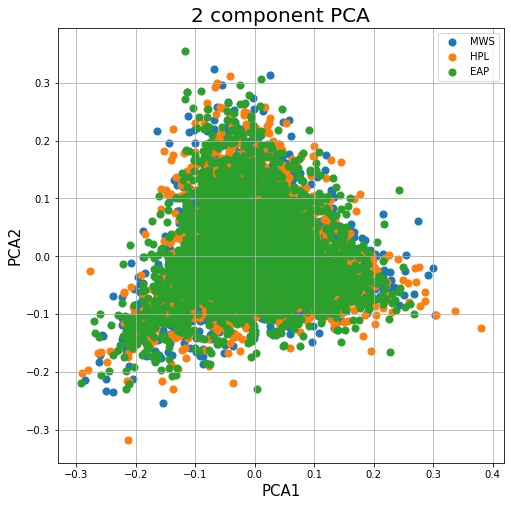

In [15]:
from matplotlib import colors as mcolors
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PCA1', fontsize = 15)
ax.set_ylabel('PCA2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ac.tlabels.unique()

for target in targets:
    indicesToKeep = finaldf['author'] == target
    ax.scatter(finaldf.loc[indicesToKeep, 'PCA1']
               , finaldf.loc[indicesToKeep, 'PCA2']
               , s = 50)
ax.legend(targets)
ax.grid()

## Fit linear model with different parameters
We try out multiple options of SVC for linear SVM: C value, tolerance value, decision_function_shape (strategy to do multi-class). Results (see below) suggest that there isn't much impact from these parameters and the accuracy score stays at around 92%. 
cvalue    tolvalue    decision_function_shape    accuracy_score
0.1       0.001       ovr (one-v-rest)           92.5%
1         0.0001      ovr                        92.5%
1         0.001       ovo (one-v-one)            92.5%
0.1       0.0001      ovo                        92.5%


In [18]:
# Fit and predict with SVM model - different params 
def svc_fit_predict(kernel, cvalue = 1, tolvalue = 0.001, decision_function_shape = 'ovr' ):
    clf = svm.SVC(kernel='linear', random_state = 0)
    clf.fit(ac.tX, ac.tlabels)
    predicted_labels = clf.predict(ac.vX)
    print("C: ", cvalue, "tol: ", tolvalue, "decision-function-shape: ", decision_function_shape, " Accuracy score: ", metrics.accuracy_score(ac.vlabels, predicted_labels))

svc_fit_predict(kernel = 'linear', cvalue = 0.1, tolvalue = 0.001, decision_function_shape = 'ovr' )
svc_fit_predict(kernel = 'linear', cvalue = 1, tolvalue = 0.0001, decision_function_shape = 'ovr' )
svc_fit_predict(kernel = 'linear', cvalue = 1, tolvalue = 0.001, decision_function_shape = 'ovo' )
svc_fit_predict(kernel = 'linear', cvalue = 0.1, tolvalue = 0.0001, decision_function_shape = 'ovo' )


C:  0.1 tol:  0.001 decision-function-shape:  ovr  Accuracy score:  0.9253655110770606
C:  1 tol:  0.0001 decision-function-shape:  ovr  Accuracy score:  0.9253655110770606
C:  1 tol:  0.001 decision-function-shape:  ovo  Accuracy score:  0.9253655110770606
C:  0.1 tol:  0.0001 decision-function-shape:  ovo  Accuracy score:  0.9253655110770606


## Run each of the other classifiers and check the accuracy and run-time
We run other classifers - poly (degree 3), rbf, sigmoid. 
sigmoid provides the worst accuracy score of 88.7%, while the other 2 are more than 90%. Poly took the most time to fit and to predict, while sigmoid takes the least. rbf seems to be the best algorithm to use given accuracy and performance in this sample data. 


Kernel    Accuracy Score    Fitting Time    Prediction Time
poly      90.9%               90s         45s
rbf       95.5%               62s         44s
sigmoid   88.7%               32s         29s


In [21]:
# Fit the SVM model with different kernels
def classify_fit_predict(tX, vX, tlabels, vlabels, kernel = 'linear', degree = 3):
    # kernel has to be one of ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’
    time1 = time.time()
    clf = svm.SVC(kernel=kernel, random_state = 0)
    clf.fit(tX, tlabels)
    time2 = time.time()
    fitduration = time2 - time1
    predicted_labels = clf.predict(vX)
    time3 = time.time()
    predictduration = time3 - time2
    vscore = metrics.accuracy_score(vlabels, predicted_labels)
    return kernel, vscore, fitduration, predictduration

kernels = ['poly', 'rbf', 'sigmoid']
dlist = []
for kernel in kernels:
    dlist.append(classify_fit_predict(ac.tX, ac.vX, ac.tlabels, ac.vlabels, kernel))

for data in dlist:
        print("Kernel: ", data[0], " Score: ", data[1], " Fit Time: ", data[2], " Predict time: ", data[3])

    

                                   



Kernel:  poly  Score:  0.9090851050245802  Fit Time:  89.69335222244263  Predict time:  45.00973320007324
Kernel:  rbf  Score:  0.9547979314307604  Fit Time:  62.24121356010437  Predict time:  43.59348678588867
Kernel:  sigmoid  Score:  0.8876971206026942  Fit Time:  32.02536678314209  Predict time:  29.25580644607544
